# Analyzing Car Accidents in Canada from 1999 - 2014 using a distributed environment in PySpark

In [1]:
import pyspark as py
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('analysis').getOrCreate()
df = spark.read.csv('NCDB_1999_to_2014.csv',header=True)
df.show(10,False)

+------+------+------+------+-----+------+------+------+------+------+------+------+----+------+------+----+-----+-----+-----+------+------+------+
|C_YEAR|C_MNTH|C_WDAY|C_HOUR|C_SEV|C_VEHS|C_CONF|C_RCFG|C_WTHR|C_RSUR|C_RALN|C_TRAF|V_ID|V_TYPE|V_YEAR|P_ID|P_SEX|P_AGE|P_PSN|P_ISEV|P_SAFE|P_USER|
+------+------+------+------+-----+------+------+------+------+------+------+------+----+------+------+----+-----+-----+-----+------+------+------+
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |01  |06    |1990  |01  |M    |41   |11   |1     |UU    |1     |
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |02  |01    |1987  |01  |M    |19   |11   |1     |UU    |1     |
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |02  |01    |1987  |02  |F    |20   |13   |2     |02    |2     |
|1999  |01    |1     |08    |2    |01    |01    |UU    |5     |3     |6     |18    |01  |01    |1986  |01  |M   

In [3]:
print("Total Rows in Dataset:",df.select("*").count())

Total Rows in Dataset: 5860405


In [4]:
print("Name of Columns - Printing for reference")
df.schema.names

Name of Columns - Printing for reference


['C_YEAR',
 'C_MNTH',
 'C_WDAY',
 'C_HOUR',
 'C_SEV',
 'C_VEHS',
 'C_CONF',
 'C_RCFG',
 'C_WTHR',
 'C_RSUR',
 'C_RALN',
 'C_TRAF',
 'V_ID',
 'V_TYPE',
 'V_YEAR',
 'P_ID',
 'P_SEX',
 'P_AGE',
 'P_PSN',
 'P_ISEV',
 'P_SAFE',
 'P_USER']

In [5]:
###################
###Cleaning Data###
###################
df = df.select("*").filter(col("C_MNTH").cast("int").isNotNull())

# Total No. of Collisions together for a month.

In [13]:
collisions_month_together = df.select(col("C_MNTH").alias("Month")).groupBy("Month").count().sort("Month")
collisions_month_together.show(collisions_month.count(),False)

+-----+------+
|Month|count |
+-----+------+
|01   |499874|
|02   |423287|
|03   |417814|
|04   |392533|
|05   |468235|
|06   |520010|
|07   |537693|
|08   |547045|
|09   |512790|
|10   |515911|
|11   |499080|
|12   |525748|
+-----+------+



In [18]:
collisions_month_together_pandas_df = collisions_month_together.select("*").toPandas()

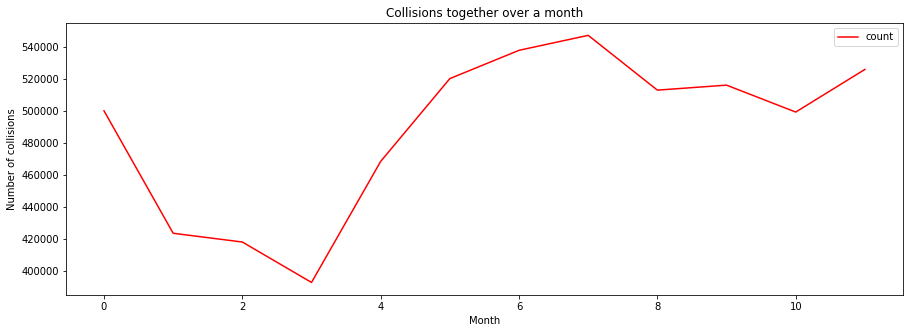

In [44]:
collisions_month_together = collisions_month_together_pandas_df.plot(figsize=(15,5),title='Collisions together over a month',color='red')
collisions_month_together.set_xlabel("Month")
collisions_month_together.set_ylabel("Number of collisions");

# Total No. of collisions in a month for each month seperately

In [30]:
collisions_month = df.select(concat(col("C_YEAR"), lit("-"), col("C_MNTH")).alias("Date")).groupBy("Date").count()
collisions_month.show(collisions_month.count(),False)

+-------+-----+
|Date   |count|
+-------+-----+
|1999-10|36269|
|2013-05|25633|
|2009-07|30136|
|1999-11|34859|
|2002-11|36328|
|2013-09|28550|
|2007-05|29243|
|2010-08|31665|
|2008-02|27352|
|2009-01|29159|
|2005-07|36104|
|2005-09|33136|
|2000-05|33618|
|2001-12|38489|
|2013-12|28415|
|2004-05|30252|
|2006-07|34880|
|2010-11|29474|
|2003-02|31473|
|2013-06|27164|
|2001-06|36270|
|2005-12|35342|
|2006-05|31240|
|2008-09|28880|
|2006-04|26243|
|2007-08|33913|
|2010-02|22557|
|1999-06|37029|
|2001-05|33579|
|2005-02|26277|
|2001-11|34228|
|2000-08|38389|
|2004-04|25101|
|2006-09|33344|
|2002-04|27825|
|2003-07|36680|
|2010-04|23968|
|2002-03|32973|
|2011-05|24768|
|2000-02|30451|
|1999-02|26538|
|2000-01|35677|
|1999-05|35481|
|2002-12|38001|
|2012-08|30218|
|2004-02|27082|
|2012-02|22233|
|2006-03|26718|
|2010-03|21511|
|2000-07|38944|
|2001-10|35870|
|2004-11|31282|
|2007-07|33728|
|2012-04|21370|
|2003-12|34459|
|2010-01|25533|
|2010-09|29620|
|2012-05|26634|
|2005-10|33054|
|2006-08

In [39]:
collisions_month_pandas_df = collisions_month.select("*").toPandas()

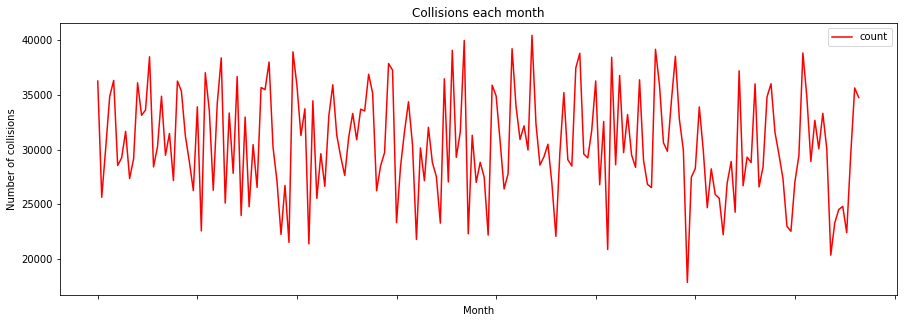

In [43]:
plot_collisions_month = collisions_month_pandas_df.plot(figsize=(15,5),x="Date",y="count",title='Collisions each month',color='red')
plot_collisions_month.set_xlabel("Month")
plot_collisions_month.set_ylabel("Number of collisions");

# No. of collisions grouped by severity in a month

In [7]:
severity = df.select(concat(col("C_YEAR"), lit("-"), col("C_MNTH")).alias("Date"), "C_SEV")
severity = severity.groupBy("Date","C_SEV").count().sort("count")
severity.show(severity.count(),False)

+-------+-----+-----+
|Date   |C_SEV|count|
+-------+-----+-----+
|2013-04|1    |230  |
|2013-03|1    |237  |
|2014-04|1    |246  |
|2014-03|1    |260  |
|2013-02|1    |280  |
|2009-03|1    |294  |
|2011-04|1    |299  |
|2012-04|1    |302  |
|2010-04|1    |313  |
|2012-02|1    |317  |
|2009-04|1    |325  |
|2014-02|1    |326  |
|2010-02|1    |327  |
|2011-03|1    |332  |
|2011-05|1    |333  |
|2010-03|1    |334  |
|2009-02|1    |335  |
|2011-02|1    |339  |
|2014-11|1    |347  |
|2003-02|1    |347  |
|2013-06|1    |349  |
|2013-12|1    |353  |
|2008-02|1    |353  |
|2014-01|1    |360  |
|2008-04|1    |362  |
|2008-03|1    |371  |
|2014-06|1    |373  |
|2014-12|1    |381  |
|2013-05|1    |381  |
|2012-06|1    |382  |
|2012-05|1    |386  |
|2014-05|1    |388  |
|2009-05|1    |391  |
|2012-11|1    |394  |
|2004-02|1    |399  |
|2004-03|1    |400  |
|2005-02|1    |403  |
|2014-09|1    |406  |
|2012-12|1    |407  |
|2012-09|1    |407  |
|2012-10|1    |408  |
|2001-01|1    |408  |
|2009-01|1

In [8]:
severity_pandas_df = severity.select("*").toPandas()

In [9]:
severity_pandas_df.head(5)

,Date,C_SEV,count
0,2013-04,1,230
1,2013-03,1,237
2,2014-04,1,246
3,2014-03,1,260
4,2013-02,1,280


# No. of Collisions depending upon weather conditions

In [10]:
collisions_weather = df.select(col("C_WTHR").alias("Weather_Condition")).groupBy("Weather_Condition").count()
collisions_weather.sort("count").show(collisions_month.count(),False)

+-----------------+-------+
|Weather_Condition|count  |
+-----------------+-------+
|Q                |15011  |
|7                |15164  |
|5                |30330  |
|6                |82438  |
|U                |87769  |
|4                |354597 |
|3                |600099 |
|2                |600220 |
|1                |4074392|
+-----------------+-------+



1 Clear and sunny
2 Overcast, cloudy but no precipitation
3 Raining
4 Snowing, not including drifting snow
5 Freezing rain, sleet, hail
6 Visibility limitation e.g. drifting snow, fog, smog, dust, smoke, mist
7 Strong wind
Q Choice is other than the preceding values
U Unknown
X Jurisdiction does not provide this data element